In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import time


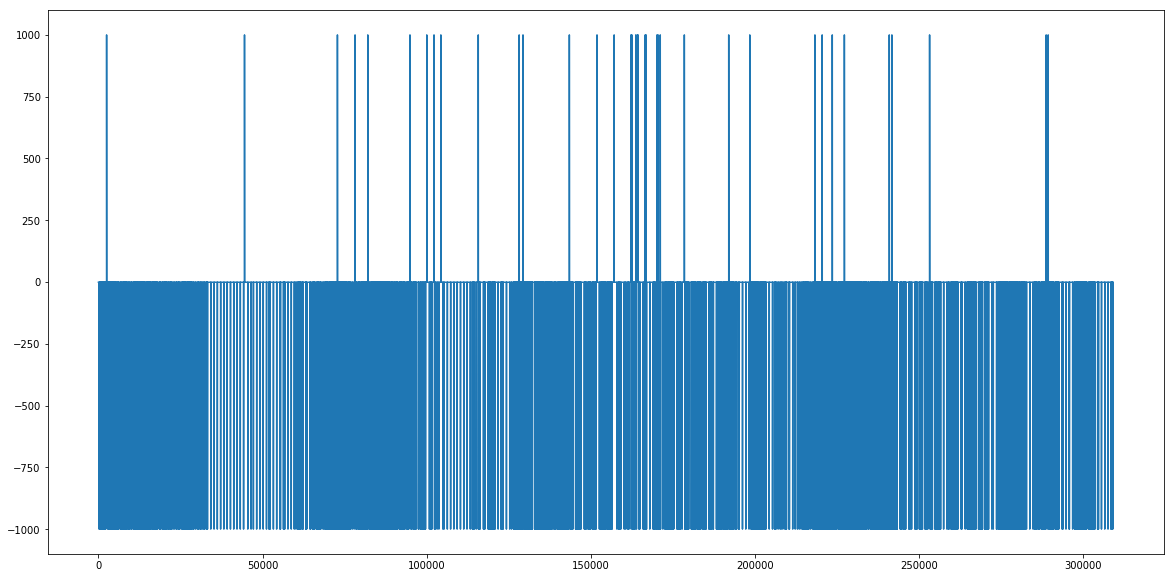

In [12]:
rewards = pd.read_csv('history.csv')
plt.figure(figsize=(20,10))
plt.plot(rewards.reward)
plt.show()
#time.sleep(10)